In [46]:
import os
import numpy as np
import cv2
import random
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import layers, models, Input
import tensorflow as tf


dataset_path = "data"
image_size = (192, 192)
unet_model_path = "Models/SegmentationModelUnet/model.keras"

dataset_path = "data"

print('Our dataset = ')
print(os.listdir(dataset_path))

Our dataset = 
['Grupo_0', 'Grupo_1', '.DS_Store', 'Grupo_4', 'Grupo_3', 'Grupo_2', 'Grupo_5']


In [50]:
def load_images_from_folder(folder_path, max_depth = 5):
    images = []
    labels = []
    names = []
    corruptedFiles = []
    image_extensions = ["bmp"]

    for root, dirs, files in os.walk(folder_path):
        current_depth = root[len(folder_path):].count(os.sep)

        if ('IriTech' in root) or ('Iritech' in root) or ('iriTech' in root) or ('iritech' in root):
            continue
        

        if current_depth <= max_depth:
            for file in files:
                if any(file.lower().endswith(ext) for ext in image_extensions):
                    img_path = os.path.join(root, file)
                    try:
                        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                        if img is not None:
                            img = cv2.resize(img, image_size)
                            img = img/255
                            images.append(img)
                            labels.append(1 if file[6]!='0' else 0)
                            names.append(file)
                    except:
                        corruptedFiles.append(img_path)

        else:
            del dirs[:]
    
    print(f"Following {len(corruptedFiles)} files are corrupt or encountered error: \n {corruptedFiles}")

    return np.array(images), np.array(labels), np.array(names)

images, labels, names = load_images_from_folder(dataset_path)
print(f"Read {len(images)} images from the data folder with shape {images.shape}")

Following 0 files are corrupt or encountered error: 
 []
Read 2820 images from the data folder with shape (2820, 192, 192)


In [26]:
#Segmenting Images
print(images.shape)

unet_model = tf.keras.models.load_model(unet_model_path)
segmentedImages = unet_model.predict(images)

print(segmentedImages.shape)

(2820, 192, 192)
89/89 ━━━━━━━━━━━━━━━━━━━━ 80s 911ms/step
(2820, 192, 192, 1)


In [51]:
images = np.expand_dims(images, -1)
print(f"Images shape changed to: {images.shape}")

Images shape changed to: (2820, 192, 192, 1)


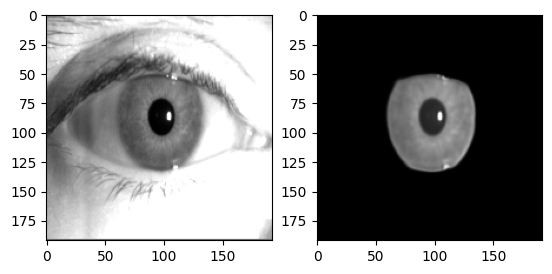

In [42]:
plt.subplot(1, 2, 1)
plt.imshow(images[90], cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(segmentedImages[90], cmap='gray')
plt.show()

In [43]:
def attention_module(x):
    # Simple attention block (SE-style)
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(x.shape[-1] // 8, activation='relu')(se)
    se = layers.Dense(x.shape[-1], activation='sigmoid')(se)
    se = layers.Reshape((1, 1, x.shape[-1]))(se)
    return layers.Multiply()([x, se])

def feature_extraction_branch(input_shape):
    inp = Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = attention_module(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    return models.Model(inp, x)

def fusion_classification_model(input_shape):
    input1 = Input(shape=input_shape, name='raw_input')
    input2 = Input(shape=input_shape, name='seg_input')

    branch = feature_extraction_branch(input_shape)

    feat1 = branch(input1)
    feat2 = branch(input2)

    # Fusion
    fused = layers.Concatenate()([feat1, feat2])
    fused = layers.Dense(64, activation='relu')(fused)
    fused = layers.Dropout(0.5)(fused)
    output = layers.Dense(1, activation='sigmoid')(fused)

    return models.Model(inputs=[input1, input2], outputs=output)


In [57]:
print(labels.shape)
lables = labels.astype("float32").reshape(-1, 1)
print(lables.shape)

(2820,)
(2820, 1)


In [60]:
images_train, images_test, segImages_train, segImages_test, labels_train, labels_test = train_test_split(images, segmentedImages, labels, test_size=0.7, random_state=23)

In [62]:
model = fusion_classification_model((192, 192, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [63]:
model.fit([images_train, segImages_train], labels_train, epochs=10, batch_size=32)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 282ms/step - accuracy: 0.7499 - loss: 0.6097
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 245ms/step - accuracy: 0.7845 - loss: 0.5410
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step - accuracy: 0.7808 - loss: 0.5356
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - accuracy: 0.7867 - loss: 0.5315
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - accuracy: 0.8026 - loss: 0.5065
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.7862 - loss: 0.5412
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - accuracy: 0.8120 - loss: 0.4921
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - accuracy: 0.8034 - loss: 0.5137
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - accuracy: 0.7945 - loss: 0.5166
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - accuracy: 0.8066 - loss: 0.5101


In [68]:
loss, accuracy = model.evaluate([images_test, segImages_test], labels_test)
print(f"CNN Test Accuracy: {accuracy * 100:.2f}%")

predictions = model.predict([images_test, segImages_test])
predicted_classes = (predictions > 0.5).astype(int).flatten()

report = classification_report(labels_test.flatten(), predicted_classes, target_names=['Fit for Duty', 'Alcoholic'])
print(report)

print(f'Overall Accuracy: {accuracy * 100:.2f}%')

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.8016 - loss: 0.5115
CNN Test Accuracy: 79.53%
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step
              precision    recall  f1-score   support

Fit for Duty       0.00      0.00      0.00       404
   Alcoholic       0.80      1.00      0.89      1570

    accuracy                           0.80      1974
   macro avg       0.40      0.50      0.44      1974
weighted avg       0.63      0.80      0.70      1974

Overall Accuracy: 79.53%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  